## Clip Image Collection 
The following script checks if the geehydro package has been installed. If not, it will install geehydro, which automatically install its dependencies, including earthengine-api and folium.

In [5]:
import subprocess

try:
    import geehydro
except ImportError:
    print('geehydro package not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geehydro'])

Import libraries

In [6]:
import ee
import folium
import geehydro
import numpy as np
import geemap
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import time
from PIL import Image
import cv2
from google.cloud import storage
import pandas as pd
import io

Authenticate and initialize Earth Engine API. You only need to authenticate the Earth Engine API once. 

In [7]:
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()


# Parameters

In [29]:
# TIME RANGE AND BIG AREAS

# time range to get the picture'
# [period_start, period_end]
time_periods = [['2022-04-25', '2022-04-29']]

# list with all the big areas to consider
# [right_top_longitude, right_top_latitude, left_bottom_longitude , left_bottom_latitude]
areas_list = [[ -78.7822,  -2.8989, -77.0138,  -7.1010],  # Amazonas province
              [ -76.0802,  -7.2645, -70.3908, -11.4990]]  # Ucayali province
areas_list = [[ -78.7822,  -2.8989, -77.0138,  -7.1010]]  # Amazonas province
areas_list = [[ -78.2131,  -4.3892, -78.0789,  -4.4885]]  # Amazonas province small area
areas_list = [[-74.0932,-9.9445,-73.8955,-10.0841]]  # Ucayali province small area
areas_list = [[-74.08988763024152,-8.137578316994567,-73.0908941319014, -9.130176898978585]]  # Ucayali province small area


 

# IMAGE PARAMETERS

# size of chip side 
chip_size = 256

# satellite scale (m)
scale = 10

# size of chip (m) 
dist =  chip_size*scale/1000*(3/5)

# overlap in chip sampling of big images
overlap = 0.33

# relevant bands
bands = ['B4','B3','B2']

# min and max pixel values
min_px = 0
max_px = 3000

# layer properties dictionary
rgbVis = {
    'bands': bands, 
    'min': min_px , 
    'max' : max_px}


# GOOGLE CLOUD PARAMETERS

# bucket name
bucket_name = 'peru_images'


# Functions

## Cloud functions
- create folder


In [30]:
# Initialize cloud storage
def init_cloud_storage(bucket_name):
    
    """
    Create a storage client for google cloud
    Inputs: - name of bucket
    Outputs: - bucket
            - storage client
    """   
    
    
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)

    return bucket, storage_client


In [31]:
def create_bucket_folder(time_period, bucket, storage_client):
    
    """
    Create a folder for each time period in the bucket and return the corresponding blob
    Inputs: - time period of the folder
            - bucket name
            - storage client
    Outputs: - folder blob
    """
    
    folder_name = f'{time_period[0]}_{time_period[1]}'
    
    if  storage.Blob(bucket=bucket, name=f'{folder_name}/').exists(storage_client) == True:
        blob = bucket.blob(f'{folder_name}/')
        blob.delete()
        
    blob = storage.Blob(f'{folder_name}/', bucket)
    blob.upload_from_string('')    
    
    return blob

## Earth Engine functions
- download big area images (pre chipping)

In [32]:
def download_big_area(time_period, area, bands):
    
    """
    Download the big area pictures (the size of a peruvian province usually)
    Inputs: - time period of the download
            - area to download
            - satellite bands
            
    Outputs: - image
    """
    
    countries = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017");
    country_selection = countries.filter(ee.Filter.Or(ee.Filter.eq("country_na","Peru"),
                                                      ee.Filter.eq("country_na","Brazil"),
                                                      ee.Filter.eq("country_na","Ecuador")))


    collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterDate(time_period[0], time_period[1]) \
          .filterBounds(country_selection)
    image1 = collection.median()

    image2 = image1.clipToCollection(country_selection)

    # Select the red, green and blue bands.
    image = image2.select(bands)
    
    r_rec = ee.Geometry.Rectangle(area)    
    clipped = image.clip(r_rec)
    
    return clipped

In [33]:
def save_image_in_bucket_folder(image, area, scale, bucket, blob):
    
    print(bucket.name)
    print(blob.name)
    
    start = time.time()
    
    start_lon = area[0]
    start_lat = area[1]
    end_lon = area[2]
    end_lat = area[3]
    
    geometry = [[start_lon,start_lat], [start_lon,end_lat], [end_lon,end_lat], [end_lon,start_lat]]

    # Export the image, specifying scale and region.
    task = ee.batch.Export.image.toCloudStorage(**{
        'image': image,
        'description': f"lon_{start_lon:.5f}_lat_{start_lat:.5f}_lon_{end_lon:.5f}_lat_{end_lat:.5f}",
        'scale': scale,
        'region': geometry,
        'fileFormat': 'GeoTIFF',
        'bucket': bucket.name,
        'formatOptions': {'cloudOptimized': True},
        'fileNamePrefix': f'{blob.name}lon_{area[0]:.5f}_lat_{area[1]:.5f}_lon_{end_lon:.5f}_lat_{end_lat:.5f}'
    })
    task.start()
    
    print(f'upload time (s) : {time.time() - start:.5f}' )

In [34]:
def save_blob(bucket,blob,time_period,area,chip_list_df):
        
    # Create a new blob
    blob = bucket.blob(f"{blob.name}lon_left_{area[0]}_lat_left_{area[1]}_lon_right_{area[2]}_lat_right_{area[3]}.pkl")

    # Create a file-like buffer to receive dataframe
    buf = io.BytesIO()

    # Convert dataframe to pickle and save it to the buffer
    chip_list_df.to_pickle(buf)
    buf.seek(0)

    # Upload the file-like object to GCS
    blob.upload_from_file(buf, content_type='application/pickle')

## Cartography functions
- distance to coordinates
- distance to latitude
- distance to longitude
- coordinates to distance

In [35]:
def dist_2_coord(lon,lat,dist):
    
    """
    Calculates the longitude and latitude of a point on the opposide corner of a square (same distance for longitude and latitude)
    Inputs: - initial longitude (top left)
            - initial latitude (top left)
            - distance
            
    Outputs:- final longitude (bottom right)
            - final latitude (bottom right)
    """
    
    # Haversine formula: dist/(2*R) = 
#             np.arcsin(np.sqrt(np.sin((r_lat_right-r_lat_left)/2)**2 + 
#             np.cos(r_lat_left)*np.cos(r_lat_right)*np.sin((r_lon_right-r_lon_left)/2)**2))

    
    R = 6378.137 # Earth radius in km  
    lat1 = lat - 2*R*np.arcsin(np.sqrt(np.sin(np.deg2rad(dist/(2*R)))**2))
    lon1 = lon + 2*R*np.arcsin(np.sqrt(np.sin(np.deg2rad(dist/(2*R)))**2/(np.cos(np.deg2rad(lat))**2)))

    return lon1, lat1

In [36]:
def dist_2_coord_lat(lat,dist):
    
    """
    Calculates the latitude of a point at a certain distance 
    Inputs: - initial latitude (top left)
            - distance in km
            
    Outputs:- final latitude (bottom right)
    """
    
    
    # Haversine formula: dist/(2*R) = 
#             np.arcsin(np.sqrt(np.sin((r_lat_right-r_lat_left)/2)**2 + 
#             np.cos(r_lat_left)*np.cos(r_lat_right)*np.sin((r_lon_right-r_lon_left)/2)**2))
    
    R = 6378.137 # Earth radius in km  
    return lat - 2*R*np.arcsin(np.sqrt(np.sin(np.deg2rad(dist/(2*R)))**2))


In [37]:
def dist_2_coord_lon(lon,lat,dist):
    
    """
    Calculates the longitude and latitude of a point at a certain distance (same distance for longitude and latitude)
    Inputs: - initial longitude (top left)
            - initial latitude (top left)
            - distance in km
            
    Outputs:- final longitude (bottom right)
    """
    
    
    # Haversine formula: dist/(2*R) = 
#             np.arcsin(np.sqrt(np.sin((r_lat_right-r_lat_left)/2)**2 + 
#             np.cos(r_lat_left)*np.cos(r_lat_right)*np.sin((r_lon_right-r_lon_left)/2)**2))

    R = 6378.137 # Earth radius in km  
    return lon + 2*R*np.arcsin(np.sqrt((np.sin(np.deg2rad(dist/(2*R)))**2/(np.cos(np.deg2rad(lat)))**2)))
                               
                               
            

In [38]:
def coord_2_dist(lon1,lat1,lon2,lat2):
    
    """
    Calculates the distance between 2 points defined by longitude and latitude
    Inputs: - initial longitude (top left)
            - initial latitude (top left)
            - final longitude (bottom right)
            - final latitude (bottom right)
            
    Outputs:- distance in km
    """
    
    # Haversine formula: dist/(2*R) = 
#             np.arcsin(np.sqrt(np.sin((r_lat_right-r_lat_left)/2)**2 + 
#             np.cos(r_lat_left)*np.cos(r_lat_right)*np.sin((r_lon_right-r_lon_left)/2)**2))

    R = 6378.137 # Earth radius in km  
  
    dist = 2*R*np.arcsin(np.sqrt(np.sin(np.deg2rad((lat2-lat1)/2))**2 + 
                                 np.cos(np.deg2rad(lat1))*np.cos(np.deg2rad(lat2))*np.sin(np.deg2rad((lon2-lon1)/2))**2))

    return dist

## Chipping functions

In [39]:
def sample_region(image,chip_df,bands,scale):
    
    """
    Creates the grid for the chips
    Inputs: - initial image
            - chip dataframe line
            - bands to get
            - scale
            
    Outputs:- Numpy array ready for models
    """
    
    def scale_values(values):
        # Get the minimum and maximum values
        max_value_allowed = 3000
        min_value = np.min(values)
        max_value = np.max(values)
        # Calculate the range of the values
        value_range = max_value_allowed - min_value
        # Scale the values to a range of 0 to 1
        scaled_values = np.array([255*((value - min_value) / value_range) for value in values]).astype(int)
        scaled_values = np.where(scaled_values >= 255, 255, scaled_values)

        return  scaled_values
    
    chunk_size = 5000
    
    print(chip_df)
   
    region = ee.Geometry.Rectangle([chip_df['lon_top_left'], 
                                    chip_df['lat_top_left'], 
                                    chip_df['lon_bottom_right'], 
                                    chip_df['lat_bottom_right']])

    # Get the number of features in the collection
    count = image.sample(region=region, scale=scale).size().getInfo()
    
    # Get the image dimensions
    rows = int(count**(1/2))
    cols = int(rows)
    
    
    if rows < 256 or cols < 256:
        print(f'CHIP SIZE WARNING!!!!\nRows : {rows} Cols : {cols}')
        return
        
    else:

        # Initialize an empty list to store the pixel values
        pixel_values = []

        # Retrieve the pixel values in chunks of chunk_size
        for i in range(0, count, chunk_size):
            # Get the next chunk of features
            features = image.sample(region=region, scale=scale).toList(chunk_size, i)

            # Extract the pixel values for the current chunk of features
            values = [[f.get('properties').get('B4'), f.get('properties').get('B3'), f.get('properties').get('B2') ]for f in features.getInfo()]

            # Append the pixel values to the list
            pixel_values.append(values)

        # Convert the list of pixel values to a numpy array
        pixel_values_list = np.concatenate(np.array(pixel_values)).ravel()



        # Reshape the pixel values array to match the original image
        pixel_values_2D = np.reshape(pixel_values_list, (rows, cols, 3))


        # Flip the image vertically and scale the values for 0-255 (maximum at 3000)
        pixel_values_2D_flipped= scale_values(np.flip(pixel_values_2D, axis = 0))

        # cut to 256x256

        pixel_values_2D_flipped = pixel_values_2D_flipped[0:256,0:256,:]


    #     # Convert the list of values into a numpy array
    #     pixel_values_np = np.column_stack(pixel_values)

        return pixel_values_2D_flipped
    
    
    
    

In [40]:
def chipping_grid(outer_area, dist, overlap):
    
    """
    Creates the grid for the chips
    Inputs: - initial longitude (top left)
            - initial latitude (top left)
            - distance
            
    Outputs:- final longitude (bottom right)
            - final latitude (bottom right)
    """

    
    start_lon = outer_area[0]
    start_lat = outer_area[1]
    end_lon = outer_area[2]
    end_lat = outer_area[3]
    
    # calculate the step in degrees for the top left corners
    lon_step =  dist_2_coord_lon(start_lon,start_lat,(1-overlap)*dist) - start_lon
    lat_step = dist_2_coord_lat(start_lat,(1-overlap)*dist) - start_lat


    # calculate the step in degrees for the top left corners

    lon_side =  dist_2_coord_lon(start_lon,start_lat,dist) - start_lon
    lat_side = dist_2_coord_lat(start_lat,dist) - start_lat    
    
    # calculate longitudes of top left corner    
    vec_lon = start_lon + lon_step*np.arange(0,(end_lon-start_lon)//lon_step,1)
    
    # calculate latitudes of top left corner
    vec_lat = start_lat + lat_step*np.arange(0,-(end_lat-start_lat)//lat_step,1)
    
    # generate matrix of top left corners llongitude and latitude
    top_left_M = np.array(np.meshgrid(vec_lon,vec_lat)).T.reshape(len(vec_lon)*len(vec_lat),2)
    
    
    # create the data frame with longitude and latitude of both corners of the chip
    chip_df = pd.DataFrame(data=top_left_M, columns=['lon_top_left', 'lat_top_left'])
    
    chip_df['lon_bottom_right'] = chip_df.apply(lambda x: x['lon_top_left']+lon_side , axis=1)
    chip_df['lat_bottom_right'] = chip_df.apply(lambda x: x['lat_top_left']+lat_side , axis=1)
    
    return chip_df
            

In [41]:
def chipping_grid_px(outer_area, dist, overlap):
    
    """
    Creates the grid for the chips
    Inputs: - initial longitude (top left)
            - initial latitude (top left)
            - distance (in pixel size) each pixel is then turned into 0.0001 degrees
            
    Outputs:- final longitude (bottom right)
            - final latitude (bottom right)
    """
    
    start_lon = outer_area[0]
    start_lat = outer_area[1]
    end_lon = outer_area[2]
    end_lat = outer_area[3]
    
    # calculate the step in degrees for the top left corners
    lon_step =  ((1-overlap)*dist)*0.0001
    lat_step = ((1-overlap)*dist)*0.0001

    # calculate the step in degrees for the top left corners
    lon_side =  dist*0.0001
    lat_side = dist*0.0001
    
    # calculate longitudes of top left corner    
    vec_lon = start_lon + lon_step*np.arange(0,(end_lon-start_lon)//lon_step,1)
    
    # calculate latitudes of top left corner
    vec_lat = start_lat - lat_step*np.arange(0,-(end_lat-start_lat)//lat_step,1)
    
    # generate matrix of top left corners llongitude and latitude
    top_left_M = np.array(np.meshgrid(vec_lon,vec_lat)).T.reshape(len(vec_lon)*len(vec_lat),2)
    
    print(f'List contains {len(top_left_M)} chips')
    
    
    # create the data frame with longitude and latitude of both corners of the chip
    chip_df = pd.DataFrame(data=top_left_M, columns=['lon_top_left', 'lat_top_left'])
    
    chip_df['lon_bottom_right'] = chip_df.apply(lambda x: x['lon_top_left']+lon_side , axis=1)
    chip_df['lat_bottom_right'] = chip_df.apply(lambda x: x['lat_top_left']-lat_side , axis=1)
    
    return chip_df

In [42]:
def point_grid(outer_area, dist_deg):
    
    """
    Creates the grid for the chips
    Inputs: - initial longitude (top left)
            - initial latitude (top left)
            - distance in degrees
            
    Outputs:- final longitude (bottom right)
            - final latitude (bottom right)
    """

    
    start_lon = outer_area[0]
    start_lat = outer_area[1]
    end_lon = outer_area[2]
    end_lat = outer_area[3]

    
    # calculate longitudes of top left corner    
    vec_lon = start_lon + dist_deg*np.arange(0,(end_lon-start_lon)//dist_deg,1)
    
    # calculate latitudes of top left corner
    vec_lat = start_lat + dist_deg*np.arange(0,-(end_lat-start_lat)//dist_deg,1)
        
    print(f'pixels horizontal : {len(vec_lon)}\npixels vertical : {len(vec_lat)}\npixels total : {len(vec_lon)*len(vec_lat)}')
    
    # generate matrix of top left corners llongitude and latitude
    point_M = np.array(np.meshgrid(vec_lon,vec_lat)).T.reshape(len(vec_lon)*len(vec_lat),2)
    
    
    # create the data frame with longitude and latitude of both corners of the chip
    point_df = pd.DataFrame(data=point_M, columns=['lon', 'lat']) 
    point_df['lon_ind'] = point_df['lon'].apply(lambda x: np.where(vec_lon == x)[0][0])
    point_df['lat_ind'] = point_df['lat'].apply(lambda x: np.where(vec_lat == x)[0][0])

    
    return point_df

# Control loop

In [43]:
# initialize cloud storage
bucket, storage_client = init_cloud_storage(bucket_name)

In [45]:
# for each relevant period
for time_period in time_periods:  
    
    # create a folder in the bucket to keep the images
#     blob = create_bucket_folder(time_period, bucket, storage_client) 
    
    print(blob)
    
    # for each relevant big area (usually a peruvian province)
    for area in areas_list: 
        
        # download the image
        big_image = download_big_area(time_period, area, bands)       
        
#         start = time.time() 
        
#         # generate chip list 
#         chip_list_df = chipping_grid_px(area, chip_size, overlap)
        
#         print(f'time to generate chip list (s) : {time.time()-start}')
        
#         start = time.time()
        
#         print(chip_list_df.head())
        
#         # sample the chips from the big initial image
#         chip_list_df['image'] = chip_list_df.apply(lambda x: sample_region(big_image,x,bands,scale), axis = 1)
        
#         print(f'time to generate the chip df (h) : {(time.time()-start)/60/60}')
        
#         save_blob(bucket,blob,time_period,area,chip_list_df)
        
        
        

<Blob: peru_images, 2022-04-25_2022-04-29/, 1675199924021567>


In [46]:
plt.imshow(chip_list_df.iloc[-1,:]['image'])

NameError: name 'chip_list_df' is not defined

In [317]:
249*249


62001

In [318]:
249*249*3

186003

In [319]:
(186390/3)**(1/2)

249.25890154616343

In [308]:
area =  [-74.0932,-9.9445,-73.8955,-10.0841]


In [309]:
big_image = download_big_area(time_period, area, bands)

In [47]:
Map = folium.Map(location=[area[1], area[0]], zoom_start=4)

Map.setOptions('ROADMAP')

In [48]:
Map.addLayer(big_image, rgbVis, 'Sentinel2')

In [49]:
# Map.addLayer(img, rgbVis, 'cloud_save')

In [50]:
# Map.centerObject(Peru, 6)
Map.setControlVisibility(layerControl=True, fullscreenControl=True, latLngPopup=True)
Map

(285, 285, 3)


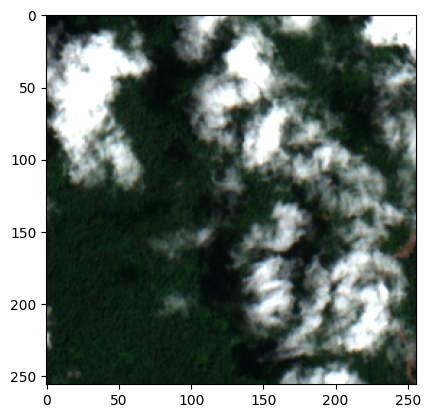

In [306]:
array_1= scale_values(pixel_values_np)

# check size 

print(array_1.shape)

# cut to 256x256

array_1 = array_1[0:256,0:256,:]

# take a look

plt.imshow(array_1)